In [1]:
import time

t = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score

from tools import datasets

In [2]:
import json

with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

with open('backups/RFECV_Forest.json') as column_file:
    F_COLUMNS = json.load(column_file)
    F_COLUMNS_QUANT = F_COLUMNS['columns_quant']
    F_COLUMNS_CAT = F_COLUMNS['columns_cat']
    F_COLUMNS = F_COLUMNS_QUANT + F_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    F_PARAMS = json.load(param_file)

print(f'Variables explicatives forêts aléatoires ({len(F_COLUMNS)}) :')
display(F_COLUMNS)

print(f'Meilleurs paramètres forêts aléatoires ({len(F_PARAMS)}) :')
F_PARAMS['class_weight'] = {int(k): v for k,v in F_PARAMS['class_weight'].items()}
display(F_PARAMS)

Variables explicatives régression logistique (11) :


['display_size',
 'nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Desktop',
 'display_env_app_ios',
 'campaignscenario_13',
 'device_type_iPhone',
 'target_env_2',
 'is_interstitial_True']

Meilleurs paramètres régression logistique (2) :


{'C': 52.98316906283702, 'class_weight': 'balanced'}

Variables explicatives forêts aléatoires (9) :


['display_size',
 'nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'dayssincelastvisitdouble',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'contextid',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêts aléatoires (7) :


{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': True}

# Régression logistique

In [3]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, verbose=False)
X = datasets_df['X_scaled']
y = datasets_df['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=1234)

In [4]:
clf = LogisticRegression(**LR_PARAMS)
clf.fit(X_train, y_train)

y_probas_LR = clf.predict_proba(X_val)[:, 1]

In [5]:
def f3_LR(seuil):
    y_pred = (y_probas_LR >= seuil) * 1
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_LR_v = np.vectorize(f3_LR)

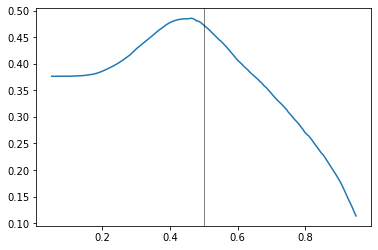

CPU times: user 20.9 s, sys: 329 ms, total: 21.2 s
Wall time: 20.9 s


In [6]:
%%time
S = np.linspace(0.05, 0.95, 150)
plt.plot(S, f3_LR_v(S))
plt.axvline(x=0.5, color='black', linewidth=0.5)
plt.show()

# Forêts aléatoires

In [7]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=F_COLUMNS_QUANT, columns_cat=F_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=1234)

In [8]:
%%time
clf = RandomForestClassifier(**F_PARAMS, n_jobs=-1)
clf.fit(X_train, y_train)

y_probas_F = clf.predict_proba(X_val)[:, 1]

CPU times: user 1h 17min 19s, sys: 36.3 s, total: 1h 17min 55s
Wall time: 10min 23s


In [9]:
def f3_F(seuil):
    y_pred = (y_probas_F >= seuil) * 1
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_F_v = np.vectorize(f3_F)

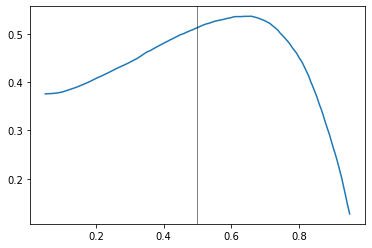

CPU times: user 21.6 s, sys: 421 ms, total: 22.1 s
Wall time: 21.8 s


In [10]:
%%time
S = np.linspace(0.05, 0.95, 150)
plt.plot(S, f3_F_v(S))
plt.axvline(x=0.5, color='black', linewidth=0.5)
plt.show()

Valeur de seuil optimale proche de 1/2 : modifier le seuil est en fait du bidouillage.